In [ ]:
!pip install scikit-learn==1.3.2 imbalanced-learn==0.12.0
import os
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 94.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm
from shutil import copy2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.applications import VGG16

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

2025-06-12 03:46:06.110156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749699966.346540      79 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749699966.415708      79 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import shutil

source_dir = "/kaggle/input/smote-odir5k/SMOTE_balanced"
target_base = "/kaggle/working/SMOTE_balanced_split"

for cls in os.listdir(source_dir):
    cls_path = os.path.join(source_dir, cls)
    if not os.path.isdir(cls_path): continue

    files = os.listdir(cls_path)
    train_files, temp_files = train_test_split(files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)  # masing2 10%

    for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_dir = os.path.join(target_base, split, cls)
        os.makedirs(split_dir, exist_ok=True)
        for file in split_files:
            shutil.copy(os.path.join(cls_path, file), os.path.join(split_dir, file))


In [ ]:
# 7. ImageDataGenerator & Load Data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,                # normalisasi
    rotation_range=25,             # rotasi acak max 25 derajat
    zoom_range=0.2,                # zoom in/out
    width_shift_range=0.1,         # geser ke kiri/kanan max 10%
    height_shift_range=0.1,        # geser ke atas/bawah max 10%
    shear_range=0.2,               # distorsi miring
    horizontal_flip=True,          # flip horizontal (boleh utk fundus)
    brightness_range=[0.7, 1.3],   # ubah kecerahan
    fill_mode='nearest'            # isi piksel kosong setelah augmentasi
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "/kaggle/working/SMOTE_balanced_split/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    "/kaggle/working/SMOTE_balanced_split/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    "/kaggle/working/SMOTE_balanced_split/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 28584 images belonging to 8 classes.
Found 3576 images belonging to 8 classes.
Found 3576 images belonging to 8 classes.


In [ ]:
class_names = list(train_gen.class_indices.keys())
print("Class names:", class_names)

Class names: ['AMD', 'Cataract', 'Diabetes', 'Glaucoma', 'Hypertension', 'Myopia', 'Normal', 'Others']


In [ ]:
from PIL import Image

img = Image.open("/kaggle/working/SMOTE_balanced_split/test/AMD/smote_10030.jpg")
print(img.mode)

RGB


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.6),

    tf.keras.layers.Dense(8, activation='softmax')  # 8 classes for ODIR
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749700200.427484      79 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749700200.428235      79 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,839,304 (7.02 MB)

 Trainable params: 1,837,320 (7.01 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose = 1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1749700212.369396     137 service.cc:148] XLA service 0x7d3028109020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749700212.370403     137 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749700212.370424     137 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749700213.036800     137 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/894 ━━━━━━━━━━━━━━━━━━━━ 1:13 82ms/step - accuracy: 0.0625 - loss: 2.9916  

I0000 00:00:1749700220.576638     137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


894/894 ━━━━━━━━━━━━━━━━━━━━ 355s 382ms/step - accuracy: 0.2731 - loss: 2.0265 - val_accuracy: 0.4002 - val_loss: 1.6092
Epoch 2/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 329s 368ms/step - accuracy: 0.4076 - loss: 1.5862 - val_accuracy: 0.4947 - val_loss: 1.3807
Epoch 3/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 329s 368ms/step - accuracy: 0.4449 - loss: 1.4759 - val_accuracy: 0.5098 - val_loss: 1.3092
Epoch 4/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 330s 369ms/step - accuracy: 0.4833 - loss: 1.3746 - val_accuracy: 0.5411 - val_loss: 1.2614
Epoch 5/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 334s 373ms/step - accuracy: 0.5135 - loss: 1.2969 - val_accuracy: 0.5604 - val_loss: 1.1816
Epoch 6/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 331s 370ms/step - accuracy: 0.5444 - loss: 1.2282 - val_accuracy: 0.6116 - val_loss: 1.1079
Epoch 7/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 328s 367ms/step - accuracy: 0.5685 - loss: 1.1661 - val_accuracy: 0.4916 - val_loss: 1.3891
Epoch 8/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 333s 372ms/step - accuracy: 0.5970 - loss: 1.09

In [ ]:
local_weights_file = '/kaggle/input/vgg16-pre-trained/keras/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = VGG16(weights='imagenet',
                              include_top=False,
                              input_shape=(224,224, 3))

  #pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layers in pre_trained_model.layers:
    layers.trainable = False



  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.models.functional.Functional'>


In [ ]:
# 8. Bangun Model VGG-16
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models


def create_pre_trained_model(local_weights_file):
    # Load pre-trained VGG16 model without the top layer
    pre_trained_model = VGG16(weights='imagenet',  # Use ImageNet weights
                               include_top=False,   # Exclude fully connected layer
                               input_shape=(224, 224, 3))  # Input shape for VGG16

    pre_trained_model.load_weights(local_weights_file)

    # Freeze all layers in the pre-trained model to prevent training
    for layer in pre_trained_model.layers:
        layer.trainable = False

    # Add custom layers for your specific task
    model = models.Sequential([
        pre_trained_model,  # Add VGG16 as base model
        layers.GlobalAveragePooling2D(),# Reduce spatial dimensions
        layers.Flatten(),
        layers.Dense(224, activation='relu'),  # Fully connected layer
        layers.Dropout(0.5),  # Regularization to prevent overfitting
        layers.Dense(8, activation='softmax')  # Output layer for 8 classes
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Optimizer for training
                  loss='categorical_crossentropy',  # Multi-class classification
                  metrics=['accuracy'])  # Track accuracy

    return model

# Memanggil model dengan bobot lokal
local_weights_file = '/kaggle/input/vgg16-pre-trained/keras/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'  # Path bobot lokal
pre_trained_model = create_pre_trained_model(local_weights_file)

# Menampilkan summary model untuk memastikan
pre_trained_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 224)                 │         114,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,831,400 (56.58 MB)

 Trainable params: 116,712 (455.91 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# 9. Training Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    verbose = 1
)

Epoch 1/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 327s 366ms/step - accuracy: 0.7481 - loss: 0.6763 - val_accuracy: 0.7033 - val_loss: 0.8039
Epoch 2/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 329s 368ms/step - accuracy: 0.7559 - loss: 0.6600 - val_accuracy: 0.7508 - val_loss: 0.6659
Epoch 3/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 326s 365ms/step - accuracy: 0.7550 - loss: 0.6437 - val_accuracy: 0.7464 - val_loss: 0.6385
Epoch 4/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 329s 368ms/step - accuracy: 0.7742 - loss: 0.6088 - val_accuracy: 0.7743 - val_loss: 0.5995
Epoch 5/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 329s 368ms/step - accuracy: 0.7752 - loss: 0.5971 - val_accuracy: 0.7894 - val_loss: 0.5525
Epoch 6/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 327s 366ms/step - accuracy: 0.7847 - loss: 0.5760 - val_accuracy: 0.7911 - val_loss: 0.5564
Epoch 7/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 329s 368ms/step - accuracy: 0.7818 - loss: 0.5779 - val_accuracy: 0.7852 - val_loss: 0.5868
Epoch 8/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 327s 365ms/step - accuracy: 0.7874 -

In [ ]:
# Recompile model dengan learning rate kecil
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune selama 10 epoch
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose = 1
)

Epoch 1/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 341s 372ms/step - accuracy: 0.8980 - loss: 0.2790 - val_accuracy: 0.8798 - val_loss: 0.3415
Epoch 2/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 337s 377ms/step - accuracy: 0.9081 - loss: 0.2510 - val_accuracy: 0.8809 - val_loss: 0.3376
Epoch 3/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 329s 368ms/step - accuracy: 0.9061 - loss: 0.2550 - val_accuracy: 0.8826 - val_loss: 0.3347
Epoch 4/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 329s 368ms/step - accuracy: 0.9127 - loss: 0.2416 - val_accuracy: 0.8820 - val_loss: 0.3383
Epoch 5/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 327s 366ms/step - accuracy: 0.9119 - loss: 0.2360 - val_accuracy: 0.8798 - val_loss: 0.3415
Epoch 6/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 331s 370ms/step - accuracy: 0.9166 - loss: 0.2289 - val_accuracy: 0.8770 - val_loss: 0.3490
Epoch 7/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 330s 369ms/step - accuracy: 0.9156 - loss: 0.2283 - val_accuracy: 0.8870 - val_loss: 0.3293
Epoch 8/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 330s 369ms/step - accuracy: 0.9149 -

  1/112 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.9688 - loss: 0.0604

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9219 - loss: 0.2097

Test Accuracy: 0.8853
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

Classification Report:
              precision    recall  f1-score   support

         AMD       0.98      0.98      0.98       447
    Cataract       0.96      0.96      0.96       447
    Diabetes       0.82      0.64      0.72       447
    Glaucoma       0.96      0.95      0.96       447
Hypertension       0.97      1.00      0.99       447
      Myopia       0.98      0.98      0.98       447
      Normal       0.62      0.83      0.71       447
      Others       0.85      0.73      0.79       447

    accuracy                           0.89      3576
   macro avg       0.89      0.89      0.89      3576
weighted avg       0.89      0.89      0.89      3576



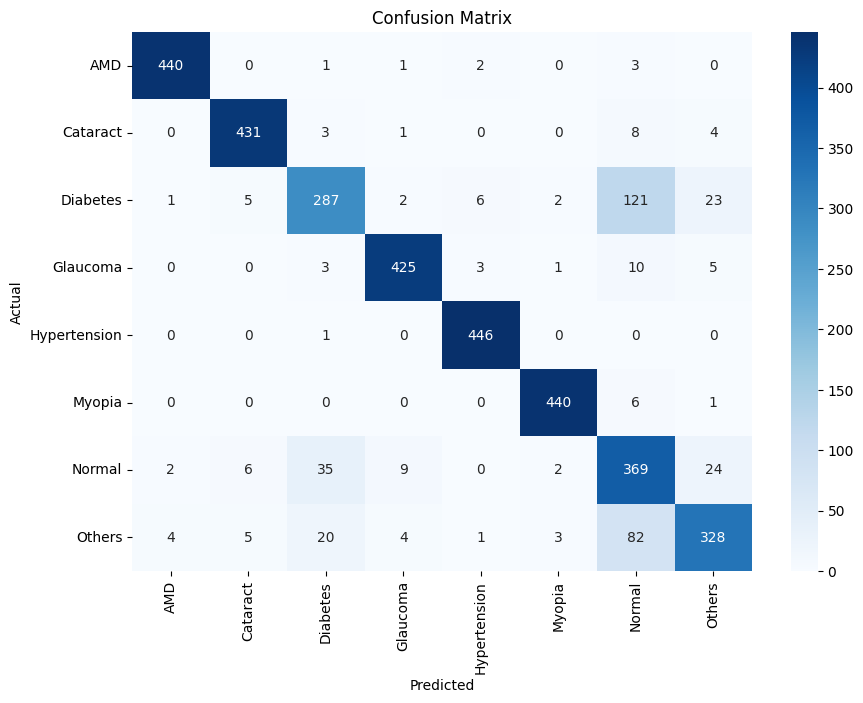

In [ ]:
# 10. Evaluasi Model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluasi Akhir
loss, acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {acc:.4f}")

# Confusion Matrix
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


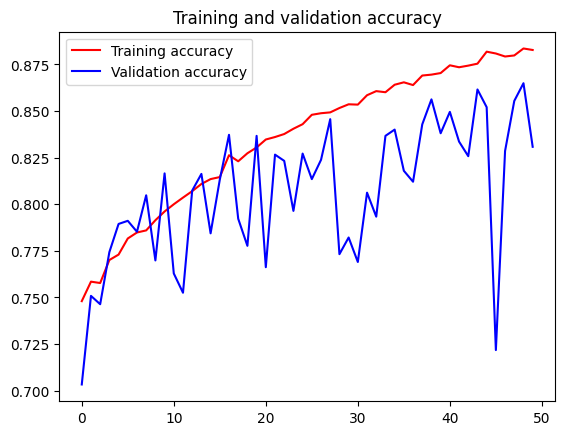

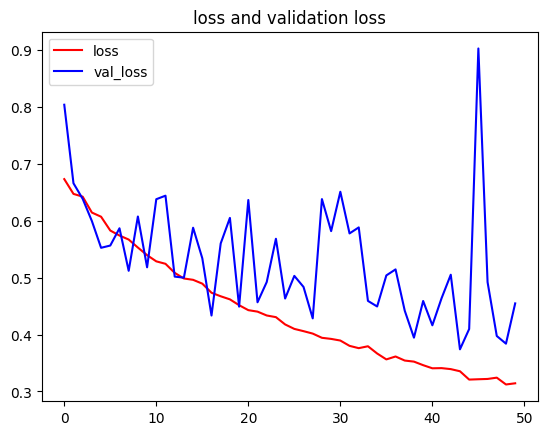

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step


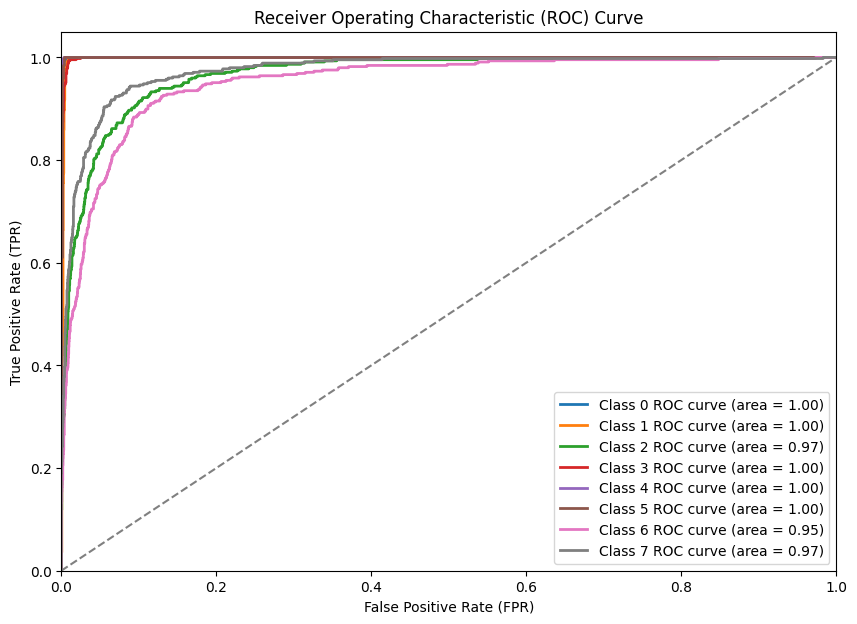

AUC for class 0: 0.9995
AUC for class 1: 0.9979
AUC for class 2: 0.9660
AUC for class 3: 0.9989
AUC for class 4: 0.9999
AUC for class 5: 0.9997
AUC for class 6: 0.9516
AUC for class 7: 0.9742


In [ ]:
# Mendapatkan probabilitas prediksi untuk setiap kelas
y_pred_prob = model.predict(test_gen, batch_size=32)

# Label sebenarnya
y_true = test_gen.classes

# Jumlah kelas (misalnya 8 untuk ODIR-5K)
n_classes = y_pred_prob.shape[1]

# Inisialisasi dictionary untuk FPR, TPR, dan AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Hitung ROC curve dan AUC untuk setiap kelas
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])  # One-vs-Rest (OvR) approach
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve untuk setiap kelas
plt.figure(figsize=(10, 7))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Menampilkan AUC untuk setiap kelas
for i in range(n_classes):
    print(f"AUC for class {i}: {roc_auc[i]:.4f}")

In [ ]:
model.save('/kaggle/working/mymodel/model_vgg16_full.h5')